# Calculating FOM by true information

In [1]:
# import stuff
import sys,os,os.path

#sys.path.append("../../")   # cite IC from parent directory
sys.path.append("/gluster/data/next/software/IC_satkill/")
#sys.path.append("/gluster/data/next/software/IC_sophronia/")
#sys.path.append(os.path.expanduser('~/code/eol_hsrl_python'))
sys.path.append(os.path.expanduser('~/code/eol_hsrl_python'))
os.environ['ICTDIR']='/gluster/data/next/software/IC_satkill/'

from    IC.invisible_cities.core.core_functions   import shift_to_bin_centers

import functions as func
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd


from functions import plot_fit as plot_fit

import scipy.special as special
from scipy.stats import skewnorm
from scipy.optimize import curve_fit

from scipy.integrate import quad

In [ ]:
# load in data

# normal location
#pre_dir = '/gluster/data/next/files/TOPOLOGY_John/HYPPOS_DATA_QTHR/BEERSHEBA_STUDY/e_cut/rel_0.2_new/'
#folder_paths = [pre_dir + 'PORT_1a/isaura/', pre_dir + 'PORT_1b/isaura/', pre_dir + 'PORT_2a/isaura/', pre_dir + 'PORT_2b/isaura/']


#060824 current directories of interest
#pre_dir = '/gluster/data/next/files/TOPOLOGY_John/HYPPOS_DATA_QTHR/BEERSHEBA_STUDY/ITER_ECUT/75_9e-3/'
#pre_dir = '/gluster/data/next/files/TOPOLOGY_John/HYPPOS_DATA_QTHR/BEERSHEBA_STUDY/e_cut/rel_0.2_new_small_isa/'
pre_dir = '/gluster/data/next/files/TOPOLOGY_John/HYPPOS_DATA_QTHR/BEERSHEBA_STUDY/e_cut/blobR_voxelS/b27v9/'
folder_paths = [pre_dir + 'PORT_1a/isaura/']

# exluding 2a
#folder_paths = [pre_dir + 'PORT_1a/isaura/', pre_dir + 'PORT_1b/isaura/', pre_dir + 'PORT_2b/isaura/']
full_tracks = func.collate_ports(folder_paths)



Porting /gluster/data/next/files/TOPOLOGY_John/HYPPOS_DATA_QTHR/BEERSHEBA_STUDY/e_cut/blobR_voxelS/b27v9/PORT_1a/isaura/
50
100


In [ ]:
unique_events = full_tracks.drop_duplicates(subset=['event', 'PORT'])
print("Done! Tracks available: {}".format(unique_events.shape[0]))

## SET MANY_PORTS HERE TO DEFINE IF YOU HAVE MANY OR ONE PORT 

In [ ]:

MANY_PORTS = False

if (MANY_PORTS == True):
    # create new id that depends on the ports, need to make sure its mirrored in the positron events
    full_tracks.insert(loc=0, column='p_evt', value=full_tracks.set_index(['event', 'PORT']).index.factorize()[0]+1)
    

In [ ]:
display(full_tracks)
#print(func.len_events(full_tracks, tag = 'p_evt'))
print(func.len_events(full_tracks, tag = 'event'))

In [ ]:
import importlib
importlib.reload(func)

In [ ]:
# apply cuts

#### THIS IS CUT OUT AS ITS NOT LEGITIMATEy
#low_e_cut_tracks = full_tracks[full_tracks.energy > 0.05]
#event_counts = low_e_cut_tracks['event'].value_counts(sort = False)
#low_e_cut_tracks['numb_of_tracks'] = low_e_cut_tracks['event'].map(event_counts)
#cut_tracks = func.apply_cuts(low_e_cut_tracks, lower_z = 20, upper_z = 1170, r_lim = 415)

cut_tracks = func.apply_cuts(full_tracks, lower_z = 20, upper_z = 1170, r_lim = 415, ports = MANY_PORTS)
cut_data = cut_tracks[0]

display(cut_tracks[0])
display(cut_tracks[1])

In [ ]:
# collect positrons
posi_dir = '/gluster/data/next/notebooks/john_books/soph_df_data/'
#pos_events = pd.read_hdf(posi_dir + 'Tl_signal_true_info.h5')
#true_info_labels = ['1a_Tl_signal_true_info.h5', '1b_Tl_signal_true_info.h5', '2a_Tl_signal_true_info.h5', '2b_Tl_signal_true_info.h5']
#true_info_labels = ['1a_Tl_signal_true_info.h5', '1b_Tl_signal_true_info.h5', '2b_Tl_signal_true_info.h5']
true_info_labels = ['1a_Tl_signal_true_info.h5']
pos_events = []

for i in range(len(true_info_labels)):
    port_id = true_info_labels[i][:2]
    data = pd.read_hdf(posi_dir + true_info_labels[i])
    data['PORT'] = str(port_id)
    if (i == 0):
        pos_events.append(data)
    else:
        # alter the event numbers
        pos_events.append(data)
    
    print(f'Positron events in {port_id}: {data.event_id.nunique()}')
#pos_events.append(pd.read_hdf(posi_dir + '1b_Tl_signal_true_info.h5'))
#pos_events.append(pd.read_hdf(posi_dir + '2a_Tl_signal_true_info.h5'))
#pos_events.append(pd.read_hdf(posi_dir + '2b_Tl_signal_true_info.h5'))

pos_events = pd.concat(pos_events, axis = 0, ignore_index = True)
# double to match the tracking info
pos_events.event_id = pos_events['event_id']*2


display(pos_events)
print(pos_events.event_id.unique())


In [ ]:
if MANY_PORTS == True:

    mapping = full_tracks.set_index(['event', 'PORT'])['p_evt'].to_dict()

    pos_events['p_evt'] = pos_events.set_index(['event_id', 'PORT']).index.map(mapping).fillna(-1).astype(int)

In [ ]:
# create new id that depends on the ports, need to make sure its mirrored in the positron events
#pos_events.insert(loc=0, column='p_evt', value=pos_events.set_index(['event_id', 'PORT']).index.factorize()[0]+1)


In [ ]:
# checking that the pos_events p_evt ids are the same as those from cut_tracks
#display(pos_events[pos_events.p_evt == 8])
#display(cut_tracks[0])

if MANY_PORTS == True:
    display(pos_events[(pos_events.p_evt).isin(cut_tracks[0].p_evt.unique())].sort_values('p_evt'))

    display(cut_tracks[0][(cut_tracks[0].p_evt).isin(pos_events.p_evt.unique())].sort_values('p_evt'))

    display(full_tracks[(full_tracks.p_evt).isin(pos_events.p_evt.unique())].sort_values('p_evt'))
    #tstsds = pos_events.groupby(['event_id', 'PORT']).size().reset_index(name='Freq')
    #print(f'Total positron events: {len(tstsds.index)}')

    # just for demonstration, apply cuts to the positron tracks from full_tracks
    test = func.apply_cuts(full_tracks[(full_tracks.p_evt).isin(pos_events.p_evt.unique())],  lower_z = 20, upper_z = 1170, r_lim = 415, ports = True)
    display(test[1])

In [ ]:
display(pos_events.event_id.to_numpy()%2 == 1)
display(cut_data.event.to_numpy()%2 == 1)

In [ ]:
#pos_events = pos_events['event_id'].unique()*2

if (MANY_PORTS == True):
    I = 'p_evt'
    # add equivalent p_evt to the pos_events
    
    pos_ids = pos_events[I].unique()# put the ids in here
else:
    I = 'event_id'
    L = 'event'
    pos_ids = pos_events[I].unique()
    
# select only events in which events have positrons
sig_data = cut_data[cut_data[L].isin(pos_ids)]
bck_data = cut_data[~cut_data[L].isin(pos_ids)]

In [ ]:
display(sig_data)
display(bck_data)
print(list(sig_data.columns))

In [ ]:
cut_list = np.linspace(0, 0.4, 41)
fom = func.true_fom_calc(sig_data, bck_data, cut_list)

In [ ]:
plt.errorbar(cut_list, fom[0], yerr = fom[1])
#plt.title("True MC across ecut 9e-3, niter 75, voxsize 12, blobR 18 LPR")
plt.title("True MC FOM across rel_cut 20% for LPR")
plt.xlabel("Blob 2 energy threshold (MeV)")
plt.xlim([0,0.4])
plt.ylim([0,4])
plt.grid()
plt.ylabel("fom")

In [17]:
fom_out = np.nan_to_num(fom[0], posinf = 0)
print(np.max(fom_out))

2.969214975098864


Text(0.5, 1.0, 'Signal and background events over blob 2 cuts')

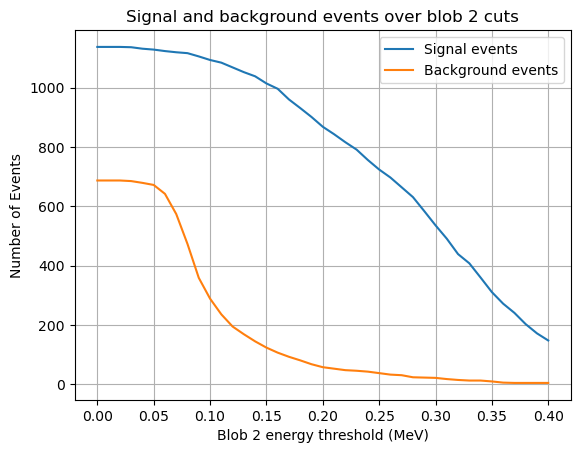

In [18]:
plt.plot(cut_list, fom[2][:-1], label = 'Signal events')
plt.plot(cut_list, fom[3][:-1], label = 'Background events')
plt.grid()
plt.xlabel('Blob 2 energy threshold (MeV)')
plt.ylabel('Number of Events')
plt.legend()
plt.title('Signal and background events over blob 2 cuts')

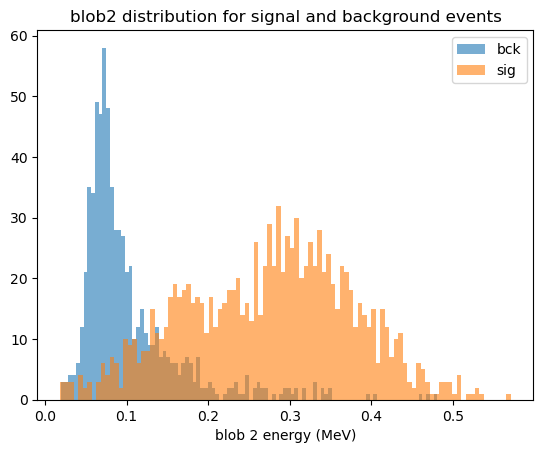

In [19]:
#sig_data, bck_data
plt.hist(bck_data.eblob2, label = 'bck', bins = 100, alpha = 0.6)
plt.hist(sig_data.eblob2, label = 'sig', bins = 100, alpha = 0.6)
plt.title('blob2 distribution for signal and background events')
plt.xlabel('blob 2 energy (MeV)')
plt.legend()
plt.show()

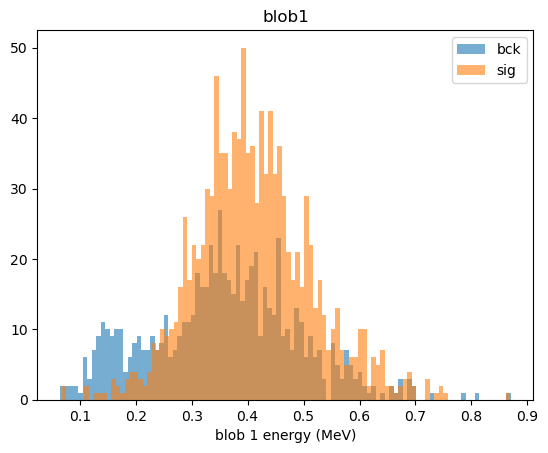

In [20]:
#sig_data, bck_data
plt.hist(bck_data.eblob1, label = 'bck', bins = 100, alpha = 0.6)
plt.hist(sig_data.eblob1, label = 'sig', bins = 100, alpha = 0.6)
plt.title('blob1')
plt.xlabel('blob 1 energy (MeV)')

plt.legend()
plt.show()

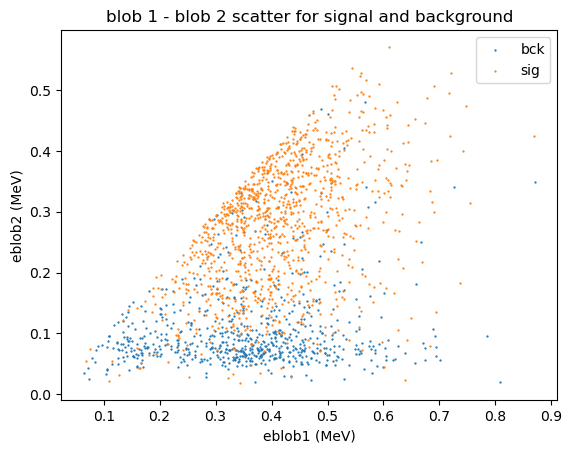

In [21]:
plt.scatter(bck_data.eblob1, bck_data.eblob2, label = 'bck', s = 0.4)
plt.scatter(sig_data.eblob1, sig_data.eblob2, label = 'sig', s = 0.4)
plt.legend()
plt.title("blob 1 - blob 2 scatter for signal and background")
plt.xlabel('eblob1 (MeV)')
plt.ylabel('eblob2 (MeV)')
plt.show()

for a separate notebook, select some events which have eblob2 energy around 0.1-0.15

In [34]:
weird_selection = sig_data[(sig_data.eblob2 < 0.16) & (sig_data.eblob2 > 0.14) & (sig_data.PORT == '1a')]
display(weird_selection)
print(weird_selection.event.to_numpy())

,p_evt,event,trackID,energy,length,numb_of_voxels,numb_of_hits,numb_of_tracks,x_min,y_min,...,blob2_x,blob2_y,blob2_z,eblob1,eblob2,ovlp_blob_energy,vox_size_x,vox_size_y,vox_size_z,PORT
805,430,500212,0,1.594830,154.342521,131,18323,1,-380.125,-60.425,...,-362.050112,-11.551377,741.474745,0.322406,0.145250,0.0,11.909091,11.142857,11.806200,1a
1615,844,360410,0,1.588748,288.259314,171,20364,1,-26.125,-99.425,...,-21.784137,-91.965008,870.371773,0.258659,0.156484,0.0,11.650000,11.666667,10.932403,1a
10479,5573,880326,0,1.599441,158.635899,120,16233,1,-33.125,137.575,...,-13.643452,152.838133,615.389819,0.353239,0.149558,0.0,11.666667,11.000000,11.911681,1a
10770,5725,880632,0,1.596445,219.443657,203,24022,1,-154.125,-44.425,...,-11.190748,74.704954,1037.503712,0.191229,0.141328,0.0,11.214286,11.545455,11.154947,1a
12501,6643,140498,0,1.595143,87.646971,99,15428,1,48.875,-351.425,...,75.149049,-344.486428,728.091591,0.209380,0.143968,0.0,10.200000,11.500000,10.555545,1a
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
181244,95747,5500348,0,1.602571,156.631022,167,18774,1,123.875,215.575,...,169.703043,340.791723,806.113021,0.214245,0.143909,0.0,11.100000,11.083333,11.449561,1a
185276,97881,5700592,0,1.600405,165.954177,131,19426,1,106.875,212.575,...,167.024471,312.701861,705.131958,0.212389,0.154985,0.0,11.181818,11.636364,11.571150,1a
187682,99143,5800362,0,1.603614,232.881516,173,23350,1,-370.125,57.575,...,-352.709939,164.655729,975.577437,0.181751,0.146796,0.0,12.000000,11.230769,10.893531,1a
187788,99200,5800476,0,1.591157,255.829175,127,13418,1,233.875,-6.425,...,240.533056,140.758732,463.615006,0.354153,0.149949,0.0,10.750000,11.923077,11.552824,1a


[ 500212  360410  880326  880632  140498 1400312  780070 1300678 1420010
 1560046 3400254 3460222 3460368 4640148 2380072 2400166 2400352 2420264
 2420484 2020596 5100182 2720126 2460486 4900236 4900564 2200130 2920164
 2220538 3320592 3360136 3040542 5080500 5080582 3240618 4340258 4660390
 4780540 5240042 5240092 5280344 5280466 5380300 5520326 5560540 5600600
 5640604 5860010 5860356 5960124 5980316  300152  520014  120106  860132
  440576  160018 1360020  580310 1000074 1880268 1820390 1980402 1580424
 1440166 1600396 1720598 4180102 4180346 2260440 2260602 2660104 3340078
 3340220 3340240 3340322 4460044 4460280 3100132 3100620 3700418 3180024
 2980156 3160430 3560008 3960556 3580280 3580598 4160120 4160460 4100438
 4260578 4520630 4820472 4720252 5160298 5500348 5700592 5800362 5800476
 5920294]


# PORT BY PORT DOWN HERE

Porting /gluster/data/next/files/TOPOLOGY_John/HYPPOS_DATA_QTHR/BEERSHEBA_STUDY/e_cut/rel_0.2_new/PORT_1a/isaura/
50
100
150
200
250
300
Done! Tracks available: 100009
Cutting events around fiducial volume related to:
Z range between 20 and 1170
Radius range < 415
Fiducial track cut
Relative Cut efficiency:
Efficiency: 42.01 %
Absolute Cut efficiency:
Efficiency: 42.01 %
One track cut
Relative Cut efficiency:
Efficiency: 53.40 %
Absolute Cut efficiency:
Efficiency: 45.49 %
Blob overlap cut
Relative Cut efficiency:
Efficiency: 79.98 %
Absolute Cut efficiency:
Efficiency: 69.08 %
Energy cut
Relative Cut efficiency:
Efficiency: 11.16 %
Absolute Cut efficiency:
Efficiency: 7.12 %


,Cut,Relative Efficiency,Relative Events,Single Cut Efficiency
0,No cuts,100.000000,100009,100.000000
1,Fiducial Cuts,42.013219,42017,42.013219
2,One track cut,53.399814,22437,45.486906
3,Blob overlap cuts,79.975041,17944,69.077783
4,Energy cuts,11.162506,2003,7.123359


Positron events in 1a: 6175


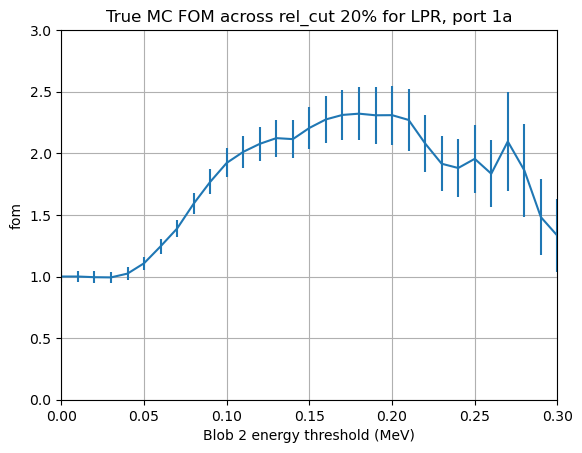

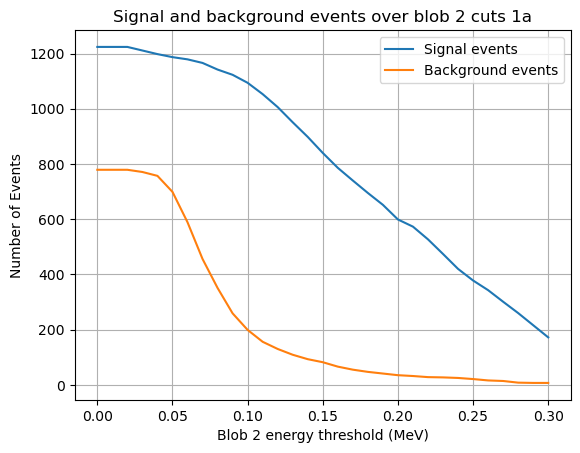

Porting /gluster/data/next/files/TOPOLOGY_John/HYPPOS_DATA_QTHR/BEERSHEBA_STUDY/e_cut/rel_0.2_new/PORT_1b/isaura/
50
100
150
200
250
Done! Tracks available: 95239
Cutting events around fiducial volume related to:
Z range between 20 and 1170
Radius range < 415
Fiducial track cut
Relative Cut efficiency:
Efficiency: 42.07 %
Absolute Cut efficiency:
Efficiency: 42.07 %
One track cut
Relative Cut efficiency:
Efficiency: 52.66 %
Absolute Cut efficiency:
Efficiency: 45.11 %
Blob overlap cut
Relative Cut efficiency:
Efficiency: 78.43 %
Absolute Cut efficiency:
Efficiency: 68.38 %
Energy cut
Relative Cut efficiency:
Efficiency: 11.10 %
Absolute Cut efficiency:
Efficiency: 7.11 %


,Cut,Relative Efficiency,Relative Events,Single Cut Efficiency
0,No cuts,100.000000,95239,100.000000
1,Fiducial Cuts,42.066800,40064,42.066800
2,One track cut,52.658247,21097,45.111771
3,Blob overlap cuts,78.428213,16546,68.381650
4,Energy cuts,11.102381,1837,7.111582


Positron events in 1b: 5969


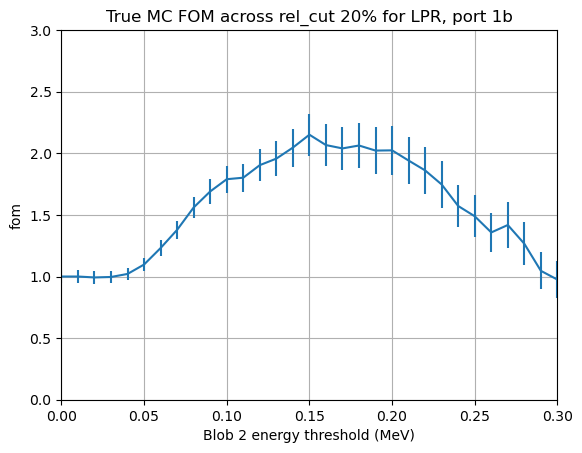

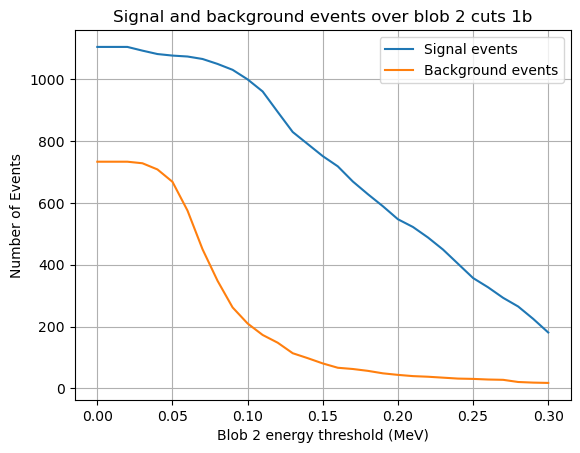

Porting /gluster/data/next/files/TOPOLOGY_John/HYPPOS_DATA_QTHR/BEERSHEBA_STUDY/e_cut/rel_0.2_new/PORT_2a/isaura/
50
100
150
200
250
300
Done! Tracks available: 71042
Cutting events around fiducial volume related to:
Z range between 20 and 1170
Radius range < 415
Fiducial track cut
Relative Cut efficiency:
Efficiency: 38.54 %
Absolute Cut efficiency:
Efficiency: 38.54 %
One track cut
Relative Cut efficiency:
Efficiency: 56.31 %
Absolute Cut efficiency:
Efficiency: 49.38 %
Blob overlap cut
Relative Cut efficiency:
Efficiency: 82.68 %
Absolute Cut efficiency:
Efficiency: 73.80 %
Energy cut
Relative Cut efficiency:
Efficiency: 10.56 %
Absolute Cut efficiency:
Efficiency: 7.20 %


,Cut,Relative Efficiency,Relative Events,Single Cut Efficiency
0,No cuts,100.000000,71042,100.000000
1,Fiducial Cuts,38.544804,27383,38.544804
2,One track cut,56.312311,15420,49.382056
3,Blob overlap cuts,82.678340,12749,73.802821
4,Energy cuts,10.557691,1346,7.202781


Positron events in 2a: 4778


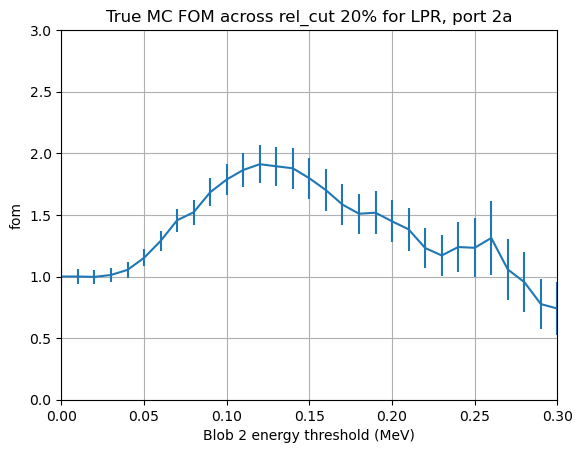

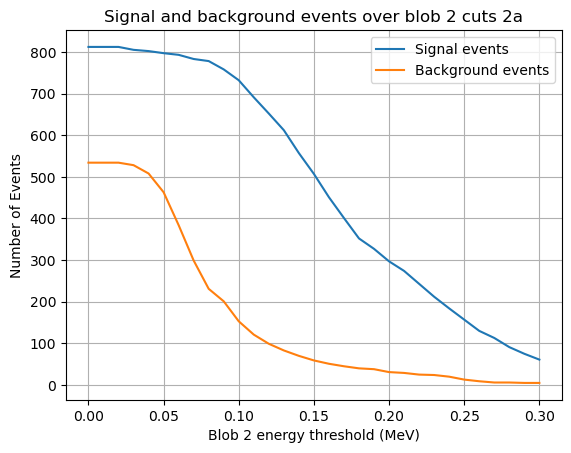

Porting /gluster/data/next/files/TOPOLOGY_John/HYPPOS_DATA_QTHR/BEERSHEBA_STUDY/e_cut/rel_0.2_new/PORT_2b/isaura/
50
100
150
200
250
300
Done! Tracks available: 95440
Cutting events around fiducial volume related to:
Z range between 20 and 1170
Radius range < 415
Fiducial track cut
Relative Cut efficiency:
Efficiency: 40.06 %
Absolute Cut efficiency:
Efficiency: 40.06 %
One track cut
Relative Cut efficiency:
Efficiency: 53.54 %
Absolute Cut efficiency:
Efficiency: 46.07 %
Blob overlap cut
Relative Cut efficiency:
Efficiency: 81.06 %
Absolute Cut efficiency:
Efficiency: 71.18 %
Energy cut
Relative Cut efficiency:
Efficiency: 10.67 %
Absolute Cut efficiency:
Efficiency: 7.15 %


,Cut,Relative Efficiency,Relative Events,Single Cut Efficiency
0,No cuts,100.000000,95440,100.000000
1,Fiducial Cuts,40.059723,38233,40.059723
2,One track cut,53.540135,20470,46.066639
3,Blob overlap cuts,81.055203,16592,71.183990
4,Energy cuts,10.667792,1770,7.147946


Positron events in 2b: 5990


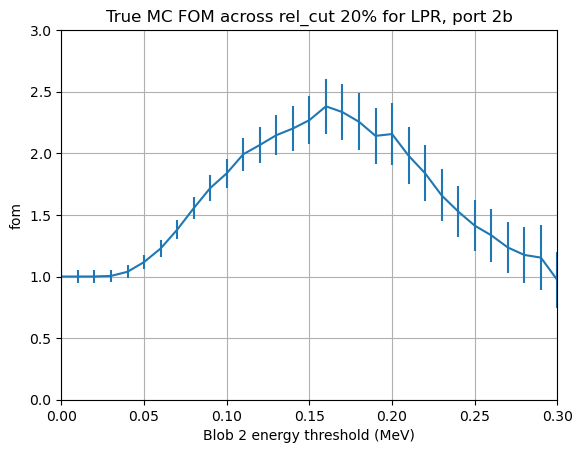

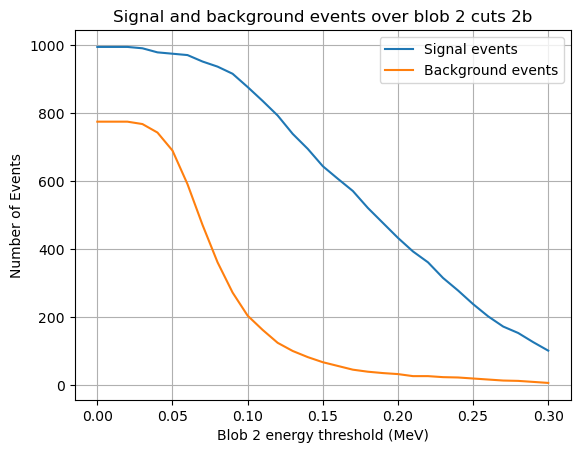

In [54]:
# load in data
pre_dir = '/gluster/data/next/files/TOPOLOGY_John/HYPPOS_DATA_QTHR/BEERSHEBA_STUDY/e_cut/rel_0.2_new/'
folder_paths = [pre_dir + 'PORT_1a/isaura/', pre_dir + 'PORT_1b/isaura/', pre_dir + 'PORT_2a/isaura/', pre_dir + 'PORT_2b/isaura/']
port_nums = ['1a', '1b', '2a', '2b']


# collect positrons
posi_dir = '/gluster/data/next/notebooks/john_books/soph_df_data/'
#pos_events = pd.read_hdf(posi_dir + 'Tl_signal_true_info.h5')
true_info_labels = ['1a_Tl_signal_true_info.h5', '1b_Tl_signal_true_info.h5', '2a_Tl_signal_true_info.h5', '2b_Tl_signal_true_info.h5']


# need to set this here as we're doing them one by one
MANY_PORTS = False

fom_array = []
fom_err_array = []

for i in range(len(folder_paths)):
    
    # load in tracking
    full_tracks = func.collate_ports([folder_paths[i]])
    cut_tracks = func.apply_cuts(full_tracks, lower_z = 20, upper_z = 1170, r_lim = 415)
    cut_data = cut_tracks[0]
    
    display(cut_tracks[1])
    
    # load in signal events
    pos_events = []
    

    port_id = true_info_labels[i][:2]
    data = pd.read_hdf(posi_dir + true_info_labels[i])
    data['PORT'] = str(port_id)
    if (i == 0):
        pos_events.append(data)
    else:
        # alter the event numbers
        pos_events.append(data)

    print(f'Positron events in {port_id}: {data.event_id.nunique()}')

    pos_events = pd.concat(pos_events, axis = 0, ignore_index = True)
    # double to match the tracking info
    pos_events.event_id = pos_events['event_id']*2

    
    if (MANY_PORTS == True):
        I = 'p_evt'
        L = 'p_evt'
        # add equivalent p_evt to the pos_events

        pos_ids = pos_events[I].unique()# put the ids in here
    else:
        I = 'event_id'
        L = 'event'
        pos_ids = pos_events[I].unique()

    # select only events in which events have positrons
    sig_data = cut_data[cut_data[L].isin(pos_ids)]
    bck_data = cut_data[~cut_data[L].isin(pos_ids)]
    
    cut_list = np.linspace(0, 0.3, 31)
    fom = func.true_fom_calc(sig_data, bck_data, cut_list)

    
    plt.errorbar(cut_list, fom[0], yerr = fom[1])
    #plt.title("True MC across ecut 9e-3, niter 75, voxsize 12, blobR 18 LPR")
    plt.title(f"True MC FOM across rel_cut 20% for LPR, port {port_nums[i]}")
    plt.xlabel("Blob 2 energy threshold (MeV)")
    plt.xlim([0,0.3])
    plt.ylim([0,3])
    plt.grid()
    plt.ylabel("fom")
    plt.show()
    
    plt.plot(cut_list, fom[2][:-1], label = 'Signal events')
    plt.plot(cut_list, fom[3][:-1], label = 'Background events')
    plt.grid()
    plt.xlabel('Blob 2 energy threshold (MeV)')
    plt.ylabel('Number of Events')
    plt.legend()
    plt.title(f'Signal and background events over blob 2 cuts {port_nums[i]}')
    plt.show()
    
    fom_array.append(fom[0])
    fom_err_array.append(fom[1])

In [54]:
for i in range(len(port_nums)):
    plt.errorbar(cut_list, fom_array[i], yerr = fom_err_array[i], label = port_nums[i])
    #plt.title("True MC across ecut 9e-3, niter 75, voxsize 12, blobR 18 LPR")
plt.title(f"True MC FOM across rel_cut 20% for LPR")
plt.xlabel("Blob 2 energy threshold (MeV)")

    

plt.xlim([0,0.3])
plt.ylim([0,3])
plt.grid()    
plt.ylabel("fom")

plt.legend()
plt.show()

NameError: name 'port_nums' is not defined

,event,time,npeak,Xpeak,Ypeak,nsipm,X,Y,Xrms,Yrms,Z,Q,E,Qc,Ec,track_id,Ep
0,0,1.412102e+06,0,-157.276758,321.125951,1,-178.825,318.775,0.0,0.0,439.872694,9.913044,354.258320,-1.0,0.001000,-1,-1.0
1,0,1.412102e+06,0,-157.276758,321.125951,1,-178.825,334.325,0.0,0.0,439.872694,11.884058,424.695627,-1.0,0.001214,-1,-1.0
2,0,1.412102e+06,0,-157.276758,321.125951,1,-178.825,349.875,0.0,0.0,439.872694,6.260870,223.742084,-1.0,0.000650,-1,-1.0
3,0,1.412102e+06,0,-157.276758,321.125951,1,-163.275,303.225,0.0,0.0,439.872694,14.318840,511.706417,-1.0,0.001442,-1,-1.0
4,0,1.412102e+06,0,-157.276758,321.125951,1,-163.275,318.775,0.0,0.0,439.872694,39.536232,1412.889842,-1.0,0.003981,-1,-1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
723968,3786,3.787648e+09,1,112.064894,121.980245,1,132.175,116.625,0.0,0.0,918.954159,27.014494,1032.045204,-1.0,0.002982,-1,-1.0
723969,3786,3.787648e+09,1,112.064894,121.980245,1,132.175,132.175,0.0,0.0,918.954159,26.028988,994.395534,-1.0,0.002872,-1,-1.0
723970,3786,3.787648e+09,1,112.064894,121.980245,1,116.625,116.625,0.0,0.0,921.954403,5.391304,522.010280,-1.0,0.001508,-1,-1.0
723971,3786,3.787648e+09,1,112.064894,121.980245,1,132.175,116.625,0.0,0.0,921.954403,4.173913,404.136976,-1.0,0.001168,-1,-1.0


(0.0, 10.0)

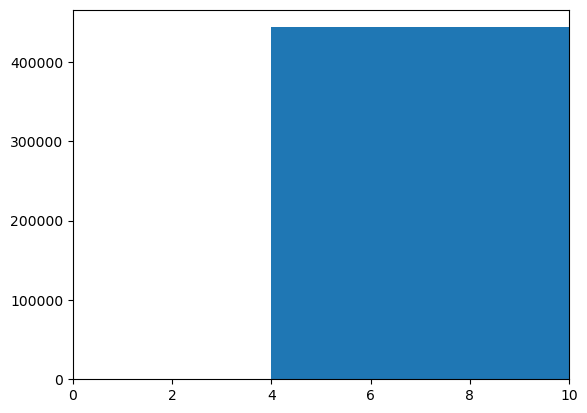